In [ ]:
##To Do:

###SHow popularity as a function of time - graph

###Most popular and familiar artist

##Song title vectorized

##Show correlation matrix of the tags

In [1]:
####Imports and Setup
import os
import sys
import time
import glob
import datetime
import sqlite3
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import patsy
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
###########################
import numpy as np
import scipy 
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
# We are using the BernoulliNB version of Naive Bayes, which assumes predictors are binary encoded.
from sklearn.naive_bayes import BernoulliNB
from sklearn.cross_validation import cross_val_score, train_test_split

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.cross_validation import cross_val_score

from sklearn.linear_model import LogisticRegressionCV

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/Users/DavisJohnson/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(12,12))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

def update_columns(col_names, label):
    new_names = []
    new_names.append(col_names[0])
    for name in col_names[1:]:
        name = label + name
        new_names.append(name)
    return new_names

def is_ascii(column):
    column_list = []
    for col in column:
        for letter in col:
            if ord(letter) > 128:
                column_list.append(col)
                continue
    return column_list

def del_cols(df):
    cols = list(df.columns.values)
    cols_del = []
    for x in cols:
        for ch in x:
            if ch not in 'abcdefghijklmnopqrstuvwxyz_0123456789-':
                cols_del.append(x)
                continue
    return cols_del

In [3]:
conn_addf_metadata = sqlite3.connect('../../Capstone/MillionSongSubset/AdditionalFiles/subset_track_metadata.db')
conn_lyric = sqlite3.connect('../../Capstone/mxm_dataset.db')

In [4]:
#Combined data set on lyrics and genres (no sub-genres in the data set)
df_lyric_comb = pd.read_csv('../Capestone/df_lyric_genre_metadata.csv')

#Combined data with sub-genres (no lyrics in the data set)
df_tags_comb = pd.read_csv('../Capestone/df_sub_genre_metadata.csv')

###Original datasets
df_songs = pd.read_sql("SELECT * FROM songs", con=conn_addf_metadata)
df_lyric = pd.read_csv('../Capestone/df_lyric_metadata.csv')
df_lyric_original = pd.read_sql("SELECT * FROM lyrics", con=conn_lyric)
df_genre_wide = pd.read_csv('../Capestone/df_genre_wide.csv') #key is 'track_id'
df_genre = pd.read_csv('../../Capstone/genre.csv')
#Original sub-genre/tag datasets
df_mbtag = pd.read_csv('../Capestone/df_term_artist_mbtag_wide.csv') #key is 'artist_id'
df_term = pd.read_csv('../Capestone/df_term_artist_term_wide.csv') #key is 'artist_id'
#Combined sub-genre/tag dataset
df_sub_genre = pd.read_csv('../Capestone/df_sub_genre.csv') #key is 'artist_id'

In [5]:
####Additional Cleaning

df_genre_wide = df_genre_wide.drop('Unnamed: 0', axis=1)
df_genre['genre_value'] = df_genre['genre_A'].map(lambda x: 1 if type(x) == str else 0)



EDA of Genre

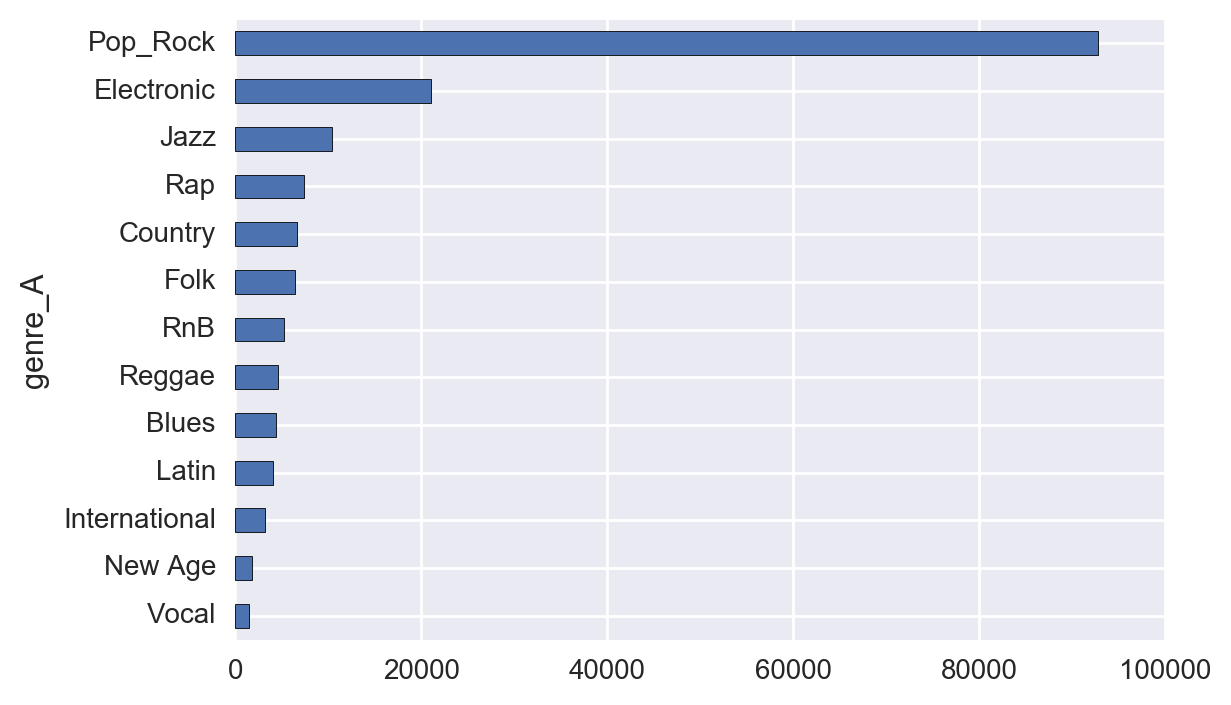

In [6]:
df_genre.groupby('genre_A')['genre_value'].sum().sort_values().plot(kind="barh")

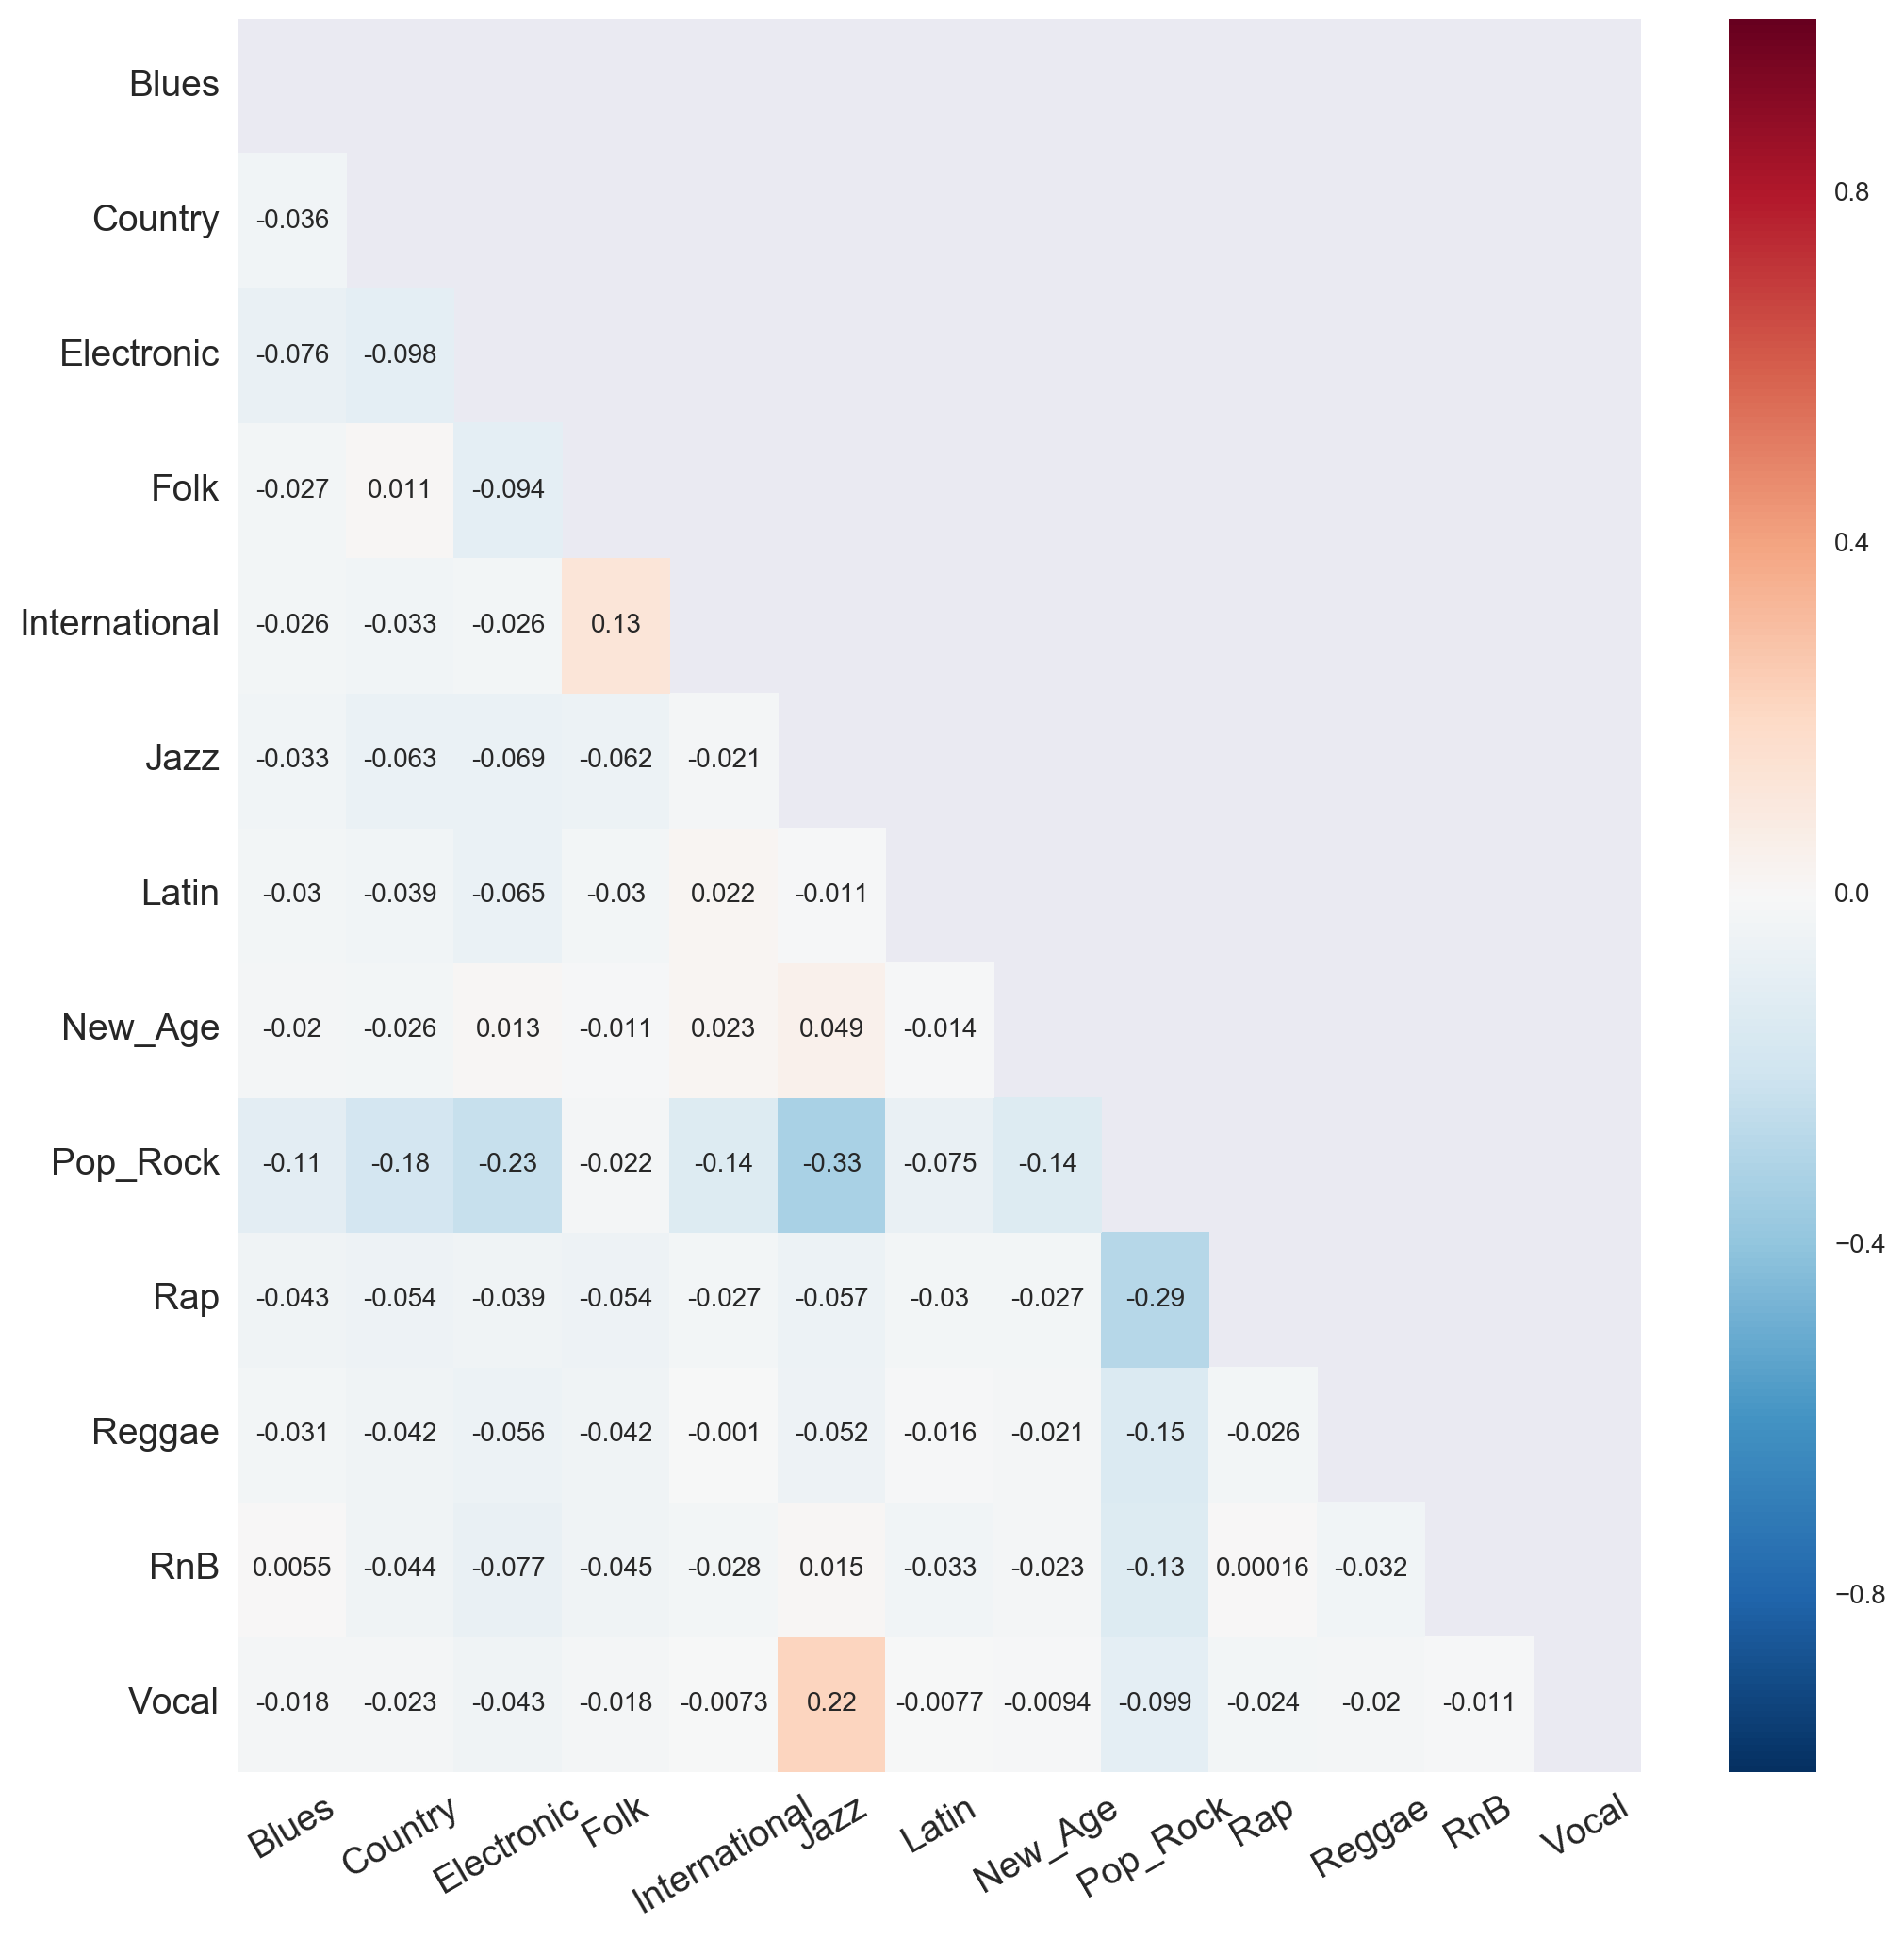

In [7]:
correlation_heat_map(df_genre_wide)

In [8]:
###Removing any non ascii characters/features from the dataframe
sub_genre_del_columns = del_cols(df_sub_genre)
term_del_columns = del_cols(df_term)
mbtag_del_columns = del_cols(df_mbtag)

In [9]:
###Drop the columns that don't have ascii characters
df_sub_genre = df_sub_genre.drop(sub_genre_del_columns, axis=1)
df_term =  df_term.drop(term_del_columns, axis=1)
df_mbtag =  df_mbtag.drop(mbtag_del_columns, axis=1)

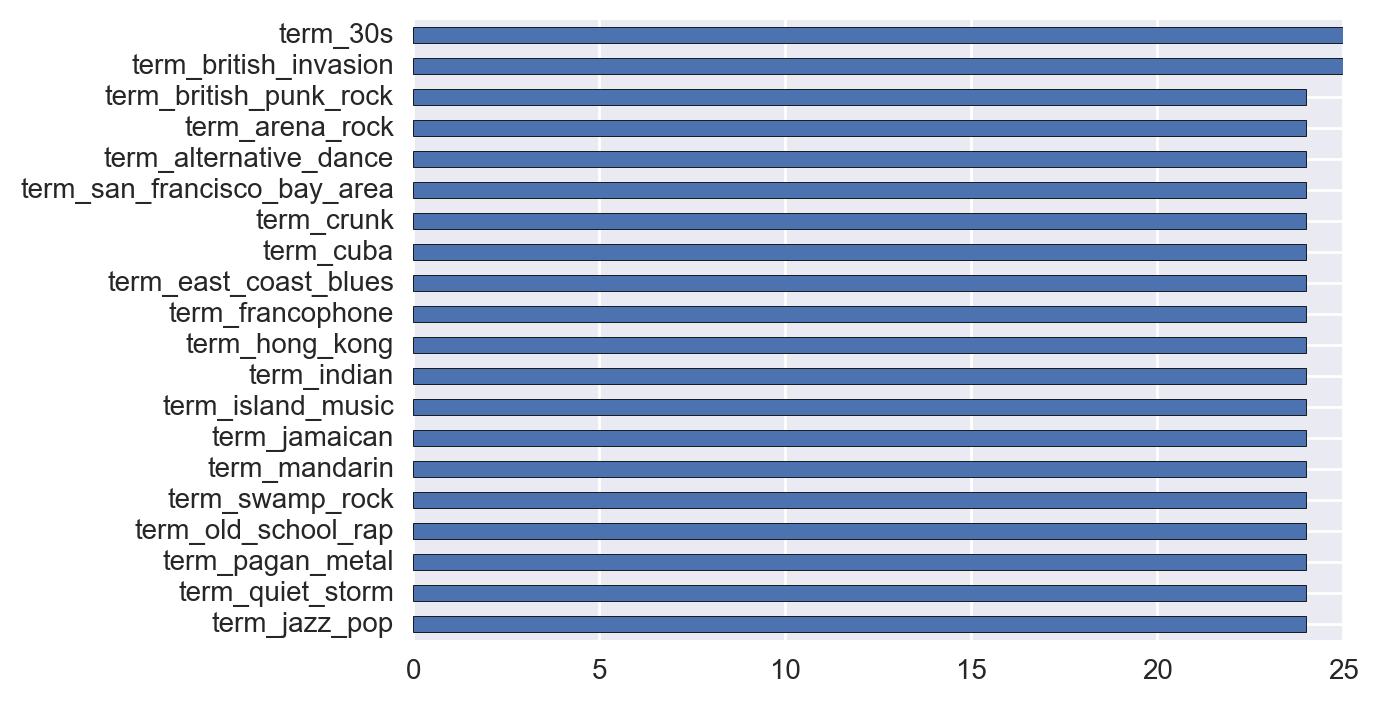

In [11]:
df_term[df_term.columns[1:]].sum().sort_values(ascending=True).head(20).plot(kind='barh')

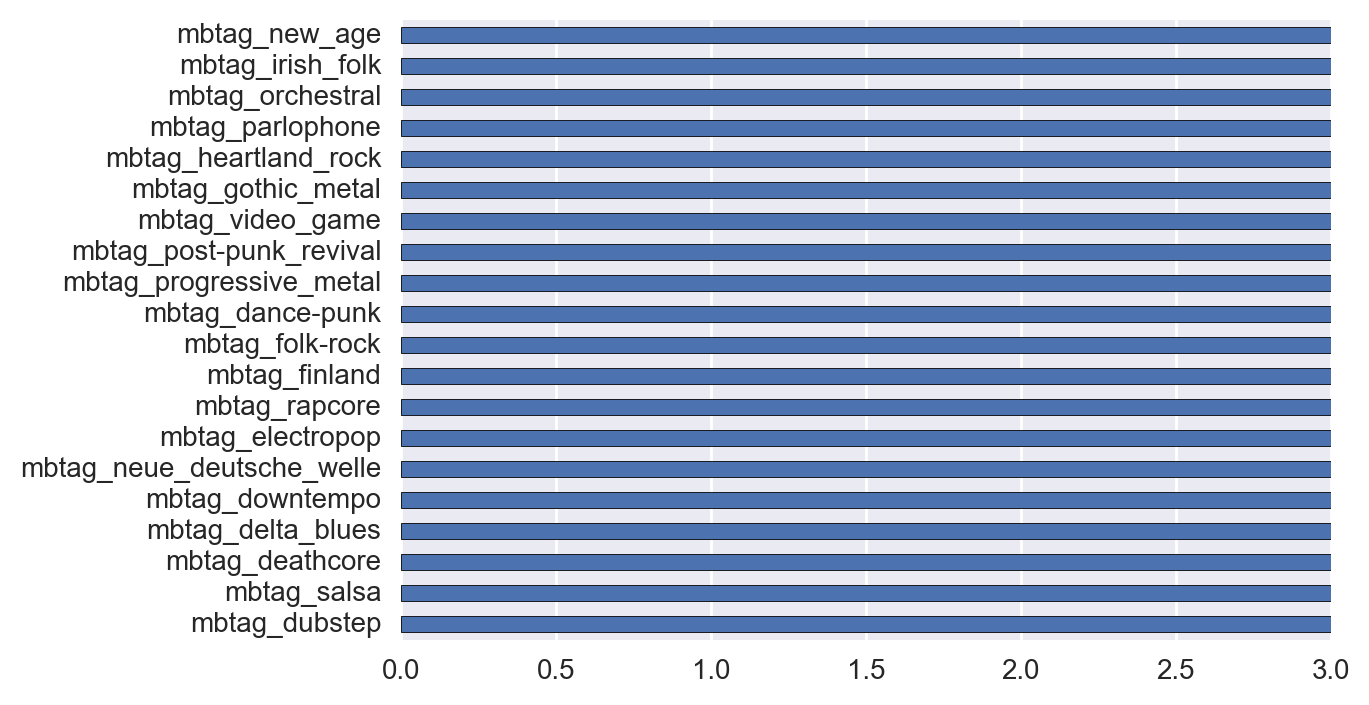

In [12]:
df_mbtag[df_mbtag.columns[1:]].sum().sort_values(ascending=True).head(20).plot(kind='barh')

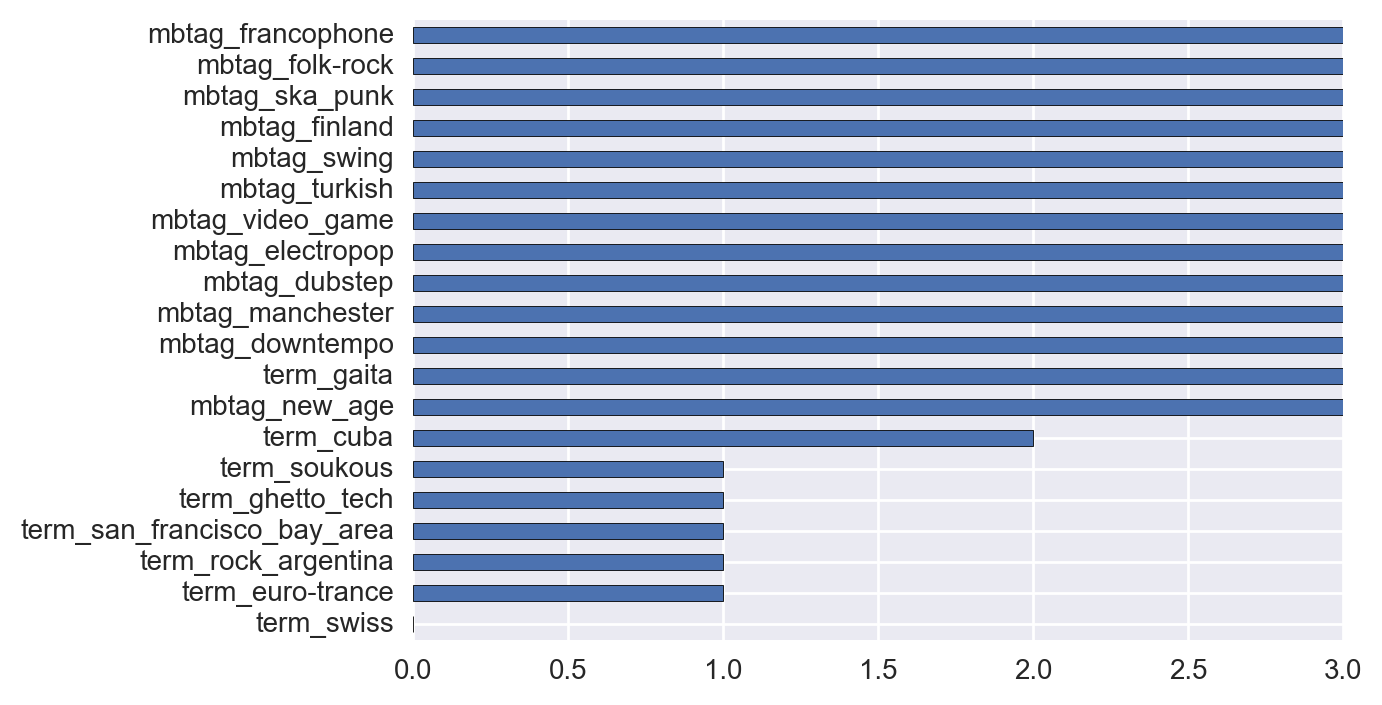

In [13]:
###Fewest of the combined tags
df_sub_genre[df_sub_genre.columns[1:]].sum().sort_values(ascending=True).head(20).plot(kind='barh')

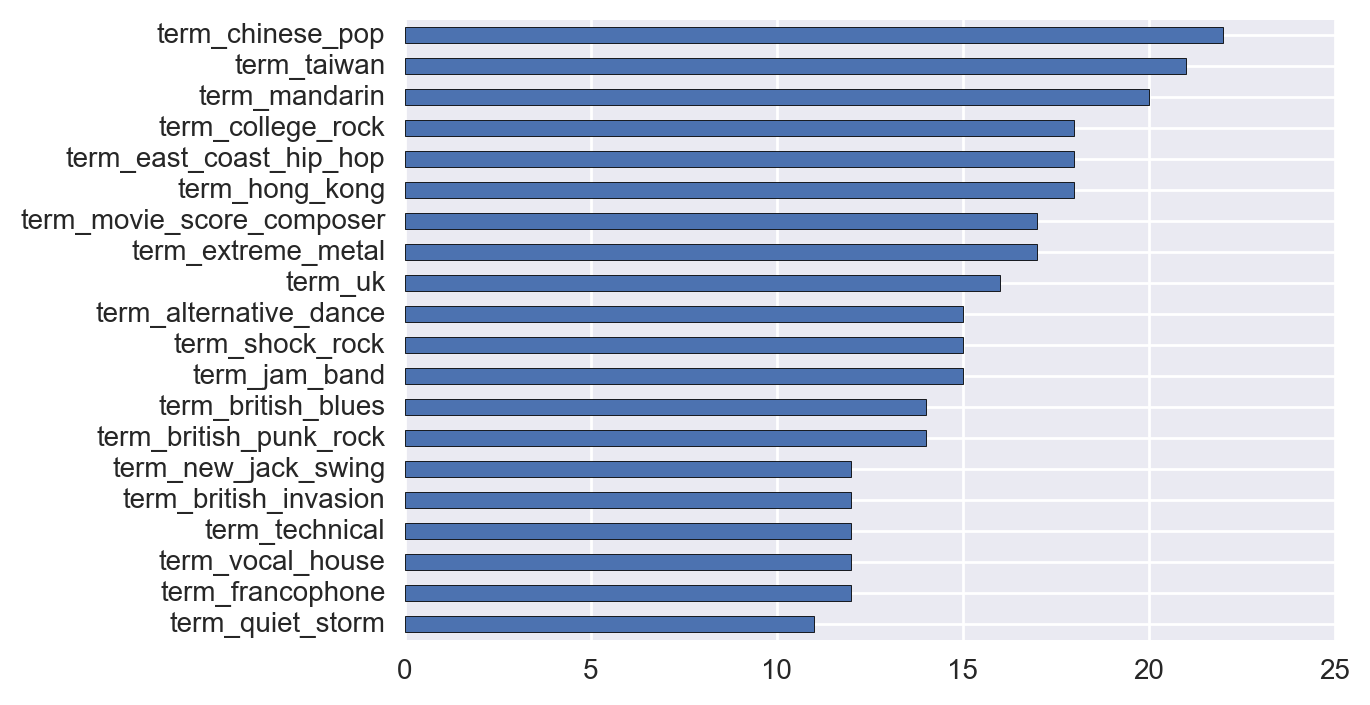

In [14]:
###Most of the combined tags
df_sub_genre[df_sub_genre.columns[1:]].sum().sort_values(ascending=True).tail(20).plot(kind='barh')

In [15]:
#Remove unwanted columns from the combined tag dataframe for linear regression
tags_combo_columns = del_cols(df_tags_comb)
df_tags_comb = df_tags_comb.drop(tags_combo_columns, axis=1)

In [16]:
df_tags_comb.shape

(3710, 218)

In [17]:
df_tags_comb = df_tags_comb[(df_tags_comb['year'] != 0)]

In [18]:
df_tags_comb.shape

(2562, 218)

In [19]:
remove_cols = ['track_id', 'title', 'song_id', 'release', 'artist_id', 'artist_mbid', 
              'artist_name', 'artist_familiarity']

In [20]:
###remove columns for modleing
df_tags_comb_pop = df_tags_comb.drop(remove_cols, axis=1)

In [21]:
df_tags_comb_pop.head()

,duration,artist_hotttnesss,year,mbtag_00s,mbtag_60s,mbtag_acid_rock,mbtag_adult_contemporary,mbtag_alternative_dance,mbtag_alternative_hip-hop,mbtag_argentina,...,term_taiwan,term_technical,term_traditional_folk,term_traditional_pop,term_twee_pop,term_uk,term_virtuoso,term_vocal_house,term_western,term_zouk
0,280.21506,0.574275,2001,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,262.89587,0.574275,2004,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,654.28853,0.574275,2009,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,233.58649,0.574275,2001,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,197.19791,0.471224,2000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
####Able to put column of what I want at the beginning for predicting capabilities
cols = df_tags_comb_pop.columns.tolist()
cols = cols[1:] + cols[:1]
df_tags_comb_pop = df_tags_comb_pop[cols]

In [23]:
df_tags_comb_pop.head()

,artist_hotttnesss,year,mbtag_00s,mbtag_60s,mbtag_acid_rock,mbtag_adult_contemporary,mbtag_alternative_dance,mbtag_alternative_hip-hop,mbtag_argentina,mbtag_art_punk,...,term_technical,term_traditional_folk,term_traditional_pop,term_twee_pop,term_uk,term_virtuoso,term_vocal_house,term_western,term_zouk,duration
0,0.574275,2001,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,280.21506
1,0.574275,2004,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,262.89587
2,0.574275,2009,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,654.28853
3,0.574275,2001,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,233.58649
4,0.471224,2000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,197.19791


In [24]:
###Start to model the data frame for hotttness based on a linear regression
y = df_tags_comb_pop['artist_hotttnesss'].values
X = df_tags_comb_pop.iloc[:,1:]

In [25]:
X.head()

,year,mbtag_00s,mbtag_60s,mbtag_acid_rock,mbtag_adult_contemporary,mbtag_alternative_dance,mbtag_alternative_hip-hop,mbtag_argentina,mbtag_art_punk,mbtag_australia,...,term_technical,term_traditional_folk,term_traditional_pop,term_twee_pop,term_uk,term_virtuoso,term_vocal_house,term_western,term_zouk,duration
0,2001,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,280.21506
1,2004,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,262.89587
2,2009,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,654.28853
3,2001,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,233.58649
4,2000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,197.19791


In [26]:
ss = StandardScaler()

In [27]:
Xn = ss.fit_transform(X)

In [28]:
linreg = linear_model.LinearRegression()

In [29]:
linreg_scores = cross_val_score(linreg, Xn, y, cv=10)

In [30]:
print linreg_scores
print np.mean(linreg_scores)

[ -8.58184598e-02  -5.08360159e+24  -7.38141417e-03  -5.30698255e+25
  -6.22066502e+24  -4.79078495e+17  -3.56650296e+25  -1.88770337e+27
  -5.48112027e+24  -1.02148119e+27]
-3.01470480411e+26


In [31]:
###Defining what is populuar or not
df_tags_comb_pop['artist_hotttnesss'].describe()

count    2562.000000
mean        0.496323
std         0.124897
min         0.000000
25%         0.406097
50%         0.475941
75%         0.555415
max         1.082503
Name: artist_hotttnesss, dtype: float64

In [32]:
###Categorizing anything with a score above .6 as popular
df_tags_comb_pop['popularity'] = df_tags_comb_pop['artist_hotttnesss'].map(lambda x: 1 if x >= .6 else 0)

In [33]:
##Drop the 'artist_hottnesss' data
df_tags_comb_pop = df_tags_comb_pop.drop('artist_hotttnesss', axis=1)

In [34]:
###Move the target column to the front of the table
cols = df_tags_comb_pop.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_tags_comb_pop = df_tags_comb_pop[cols]

In [35]:
df_tags_comb_pop.head()

,popularity,year,mbtag_00s,mbtag_60s,mbtag_acid_rock,mbtag_adult_contemporary,mbtag_alternative_dance,mbtag_alternative_hip-hop,mbtag_argentina,mbtag_art_punk,...,term_technical,term_traditional_folk,term_traditional_pop,term_twee_pop,term_uk,term_virtuoso,term_vocal_house,term_western,term_zouk,duration
0,0,2001,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,280.21506
1,0,2004,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,262.89587
2,0,2009,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,654.28853
3,0,2001,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,233.58649
4,0,2000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,197.19791


In [65]:
###Start to model the data frame for hotttness based on a linear regression
y = df_tags_comb_pop['popularity'].values
X = df_tags_comb_pop.iloc[:,1:]

In [66]:
X.columns

Index([u'year', u'mbtag_00s', u'mbtag_60s', u'mbtag_acid_rock',
       u'mbtag_adult_contemporary', u'mbtag_alternative_dance',
       u'mbtag_alternative_hip-hop', u'mbtag_argentina', u'mbtag_art_punk',
       u'mbtag_australia',
       ...
       u'term_technical', u'term_traditional_folk', u'term_traditional_pop',
       u'term_twee_pop', u'term_uk', u'term_virtuoso', u'term_vocal_house',
       u'term_western', u'term_zouk', u'duration'],
      dtype='object', length=209)

In [67]:
ss = StandardScaler()
lrcv = LogisticRegressionCV(Cs=100, solver='liblinear', penalty='l1', cv=5)

In [68]:
Xn = ss.fit_transform(X)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=0.33)

In [70]:
#Fit the logestic model basedon the parameters
lrcv.fit(X_train, y_train)

LogisticRegressionCV(Cs=100, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

In [72]:
print 1-np.mean(y_test)
print lrcv.score(X_test, y_test)

0.858156028369
0.89243498818


In [431]:
#lrcv.coef_


###Ther residual is less than the error (so it got taken out and )

###Ridge is better for multicoliniarity (high correlation), dosen't eliminate variables
###(unlike lasso where it deletes values)

##The Lasso and Elastic Net can be very useful for when you have redundant or 
##unimportant variables. If you have 1000 variables in a dataset the Lasso 
##can perform "feature selection" 
##automatically for you by forcing coefficients to be zero.

##Justify logistic regression because I don't need to know if it's the most popular
##on a linear scale but wether it's popular or not


###GridSearch
#probably multicolinarity
#Look at regularizatioin (like Lasso)


##For Logistic regression you have to look at the baseline score. For linear regression, 
##you can just look at the R^2 above 0

In [73]:
coefs = pd.DataFrame({'coef':lrcv.coef_[0], 'abs_coef':np.abs(lrcv.coef_[0]),
                      'variable':X.columns})
coefs.sort_values('coef', ascending=False, inplace=True)

In [77]:
coefs.head(15)

,abs_coef,coef,variable
86,0.540486,0.540486,mbtag_parlophone
131,0.406988,0.406988,term_crunk
98,0.372942,0.372942,mbtag_rapper
28,0.341526,0.341526,mbtag_dance-pop
21,0.340370,0.340370,mbtag_chanteur
70,0.320877,0.320877,mbtag_irish
26,0.293747,0.293747,mbtag_college_rock
62,0.285580,0.285580,mbtag_heartland_rock
55,0.277336,0.277336,mbtag_glam_metal
76,0.265909,0.265909,mbtag_melodic_hardcore


In [78]:
coefs.tail(15)

,abs_coef,coef,variable
95,0.176181,-0.176181,mbtag_protopunk
116,0.188696,-0.188696,term_alternative_dance
82,0.192151,-0.192151,mbtag_new_york
168,0.201611,-0.201611,term_movie_score_composer
108,0.217903,-0.217903,mbtag_synthpop
144,0.218863,-0.218863,term_extreme_metal
135,0.221106,-0.221106,term_dream
183,0.226669,-0.226669,term_quiet_storm
60,0.226935,-0.226935,mbtag_guitarist
175,0.242677,-0.242677,term_old_school_rap


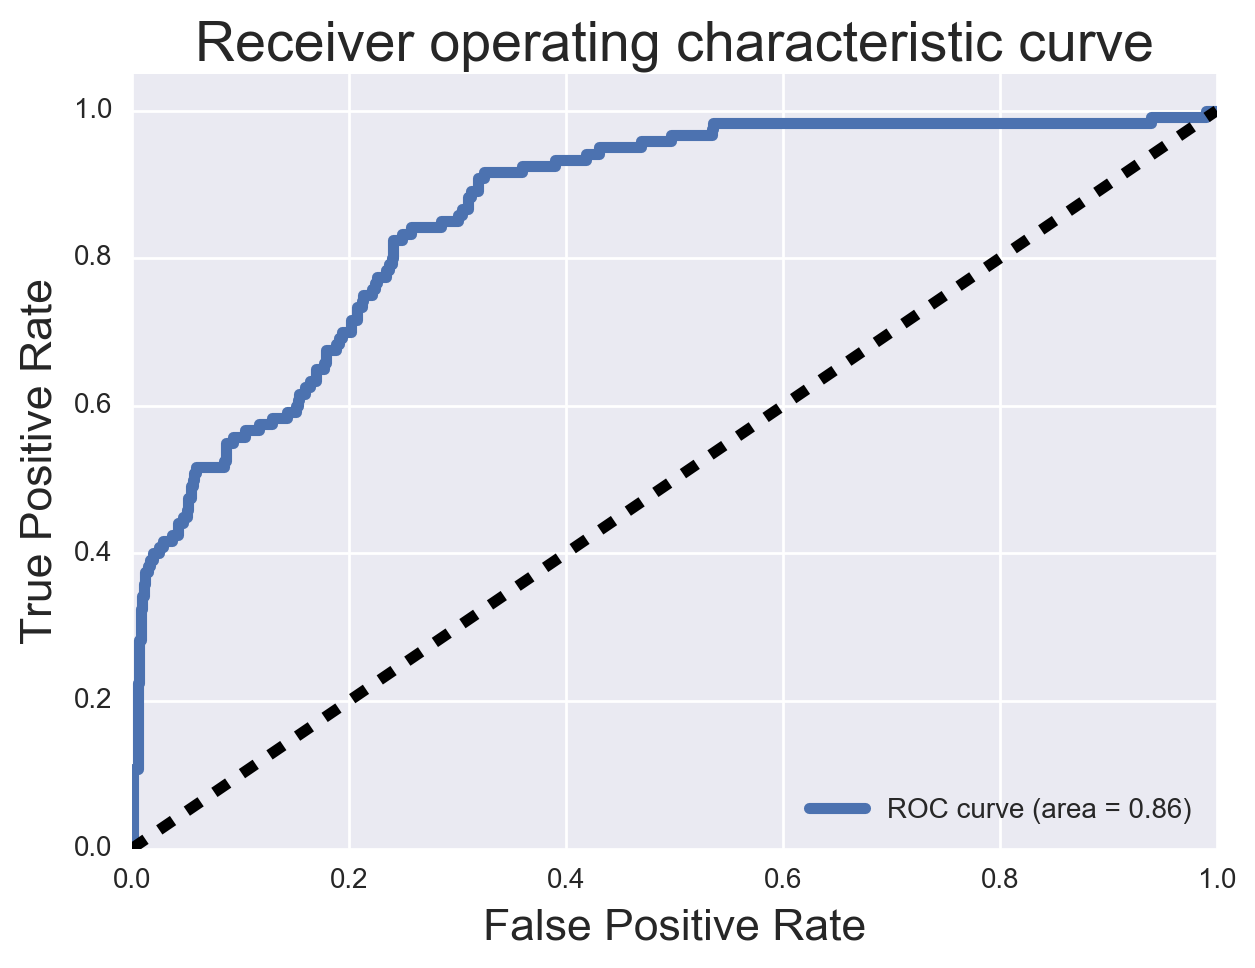

In [79]:
from sklearn.metrics import roc_curve, auc

# Get out the predicted probabilities for the X observation matrix
y_pp = lrcv.predict_proba(X_test)

# roc_curve returns the false positive rate and true positive rates as the threshold changes
# takes in the y and the predicted probabilities of the positive class from your model.
fpr, tpr, _ = roc_curve(y_test, y_pp[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[7,5])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic curve', fontsize=20)
plt.legend(loc="lower right")
plt.show()